In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

---

General variables and dictionaries

In [2]:
VARIABLE = 'MonthlyIncome'
VARIABLE2 = 'Monthly income'

PREDICTOR = 'YearsOfEducation'
PREDICTOR2 = 'Years of education'

ALPHA_LEVEL = 0.05

J = 6 # Number of regions

In [3]:
RegionsToNumbers = {
    'NorthernThailand': 0
    , 'SouthernThailand': 2
    , 'WesternThailand': 3
    , 'EasternThailand': 5
    , 'NortheastThailand': 1
    , 'CentralThailand': 4
}

In [4]:
NumbersToRegions = {
    0: 'Northern Thailand'
    , 2: 'Southern Thailand'
    , 3: 'Western Thailand'
    , 5: 'Eastern Thailand'
    , 1: 'Northeast Thailand'
    , 4: 'Central Thailand'
}

---

Read the data and give it the basic needed structure

In [5]:
ProvincesProvinceIdRegion = pd.read_csv("../../../Data/Enriched/ProvincesProvinceIdRegion.csv")

In [6]:
Dat = pd.read_csv("../../../Data/Processed/DataProvince.csv")
Dat = pd.merge(Dat, ProvincesProvinceIdRegion)
Dat['RegionNumber'] = Dat['Region'].replace(RegionsToNumbers)

In [7]:
Dat = Dat[[VARIABLE + 'Mean', PREDICTOR, 'RegionNumber']]

In [8]:
PredictorMean = Dat[PREDICTOR].mean()

---

In [9]:
DatRegion = Dat[[PREDICTOR, 'RegionNumber']].groupby(['RegionNumber']).mean().reset_index()
DatRegion = DatRegion.rename(columns={PREDICTOR: PREDICTOR + 'Region'})

Dat = pd.merge(Dat, DatRegion)

Calculate the statistics per region

In [10]:
DatRegion = Dat[[VARIABLE + 'Mean', 'RegionNumber']].groupby(['RegionNumber']).agg(['mean', 'std']).reset_index()

DatRegion.columns = DatRegion.columns.droplevel()

DatRegion = DatRegion.rename(
    columns={
        '': 'RegionNumber'
        , 'mean': VARIABLE + 'Mean'
        , 'std': VARIABLE + 'Std'
    }
)

---

Estimate $\nu$ for all the data

In [11]:
ES2 = (DatRegion[VARIABLE + 'Std']**2).mean()
VS2 = (DatRegion[VARIABLE + 'Std']**2).var()

HatNu = 2 * ES2**2 / VS2 + 4

---

Regression model with common $\alpha$ and $\beta$

In [12]:
with pm.Model() as ModelCommonAlphaCommonBeta:
    Alpha = pm.Flat('Alpha')
    Beta  = pm.Flat('Beta')

    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic('MeanIncome', Alpha + Beta * (Dat[PREDICTOR] - PredictorMean))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma, observed=Dat[VARIABLE + 'Mean'])

Regression model with separate $\alpha$'s and $\beta$'s

In [13]:
with pm.Model() as ModelSeparateAlphaSeparateBeta:
    Alpha = pm.Flat('Alpha', shape=J)
    Beta  = pm.Flat('Beta', shape=J)

    Sigma = pm.HalfFlat('Sigma', shape=J)
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , Alpha[Dat['RegionNumber']] + Beta[Dat['RegionNumber']] * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region']))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma[Dat['RegionNumber']], observed=Dat[VARIABLE + 'Mean'])

---

In [14]:
TraceCommonAlphaCommonBeta = pm.sample(model = ModelCommonAlphaCommonBeta)
TraceSeparateAlphaSeparateBeta = pm.sample(model = ModelSeparateAlphaSeparateBeta)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [15]:
HatMeanMu = TraceCommonAlphaCommonBeta.posterior.Alpha.values.mean()
HatStdMu  = TraceCommonAlphaCommonBeta.posterior.Alpha.values.std()

HatMeanBeta = TraceCommonAlphaCommonBeta.posterior.Beta.values.mean()
HatStdBeta  = TraceCommonAlphaCommonBeta.posterior.Beta.values.std()

HatMeanTau = float(TraceSeparateAlphaSeparateBeta.posterior.Alpha.mean(('chain', 'draw')).std().values)

---

In [16]:
with pm.Model() as ModelVaryingAlphaCommonBeta:

    Tau   = pm.Exponential('Tau', lam=1/HatMeanTau)
    Mu    = pm.Normal('Mu', mu=HatMeanMu, sigma=HatStdMu) # National average income
    Alpha = pm.Normal('Alpha', mu=Mu, sigma=Tau, shape=J) # Regional average income

    Beta = pm.Normal('Beta', mu=HatMeanBeta, sigma=HatStdBeta)

    Rho = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu = pm.Exponential('Nu', lam=1/HatNu)

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , Alpha[Dat['RegionNumber']] + Beta * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region']))

    Income = pm.Normal(
        'Income'
        , mu = MeanIncome
        , sigma = Sigma[Dat['RegionNumber']]
        , observed = Dat[VARIABLE + 'Mean']
    )

Get a sample from the posterior and the posterior predictive

In [17]:
with ModelVaryingAlphaCommonBeta:
    TraceVaryingAlphaCommonBeta = pm.sample()
    TraceVaryingAlphaCommonBeta.extend(pm.sample_posterior_predictive(TraceVaryingAlphaCommonBeta))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tau, Mu, Alpha, Beta, Rho, Nu, Sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
Sampling: [Income]


---

Regional average income, ratio of income per year-of-education

In [18]:
DatRegion['Region'] = DatRegion['RegionNumber'].replace(NumbersToRegions)

In [19]:
PosteriorAlpha = az.summary(
    TraceSeparateAlphaSeparateBeta
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'Alpha'
)

PosteriorAlpha = PosteriorAlpha.rename(
    columns = {
        'mean': 'HatAlpha'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100)  + '%': 'LowAlpha'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%': 'UppAlpha'
    }
)

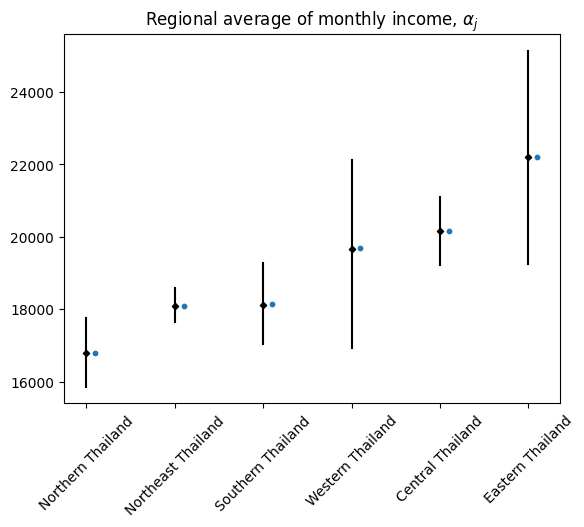

In [20]:
plt.scatter(range(J), PosteriorAlpha['HatAlpha'], marker='D', color='k', s=10)
plt.scatter(np.arange(0.1, J+0.1, 1), DatRegion[VARIABLE + 'Mean'], marker='o', color='C0', s=10)

for j in range(J):
    plt.plot(
        [j, j],
        [PosteriorAlpha['LowAlpha'][j], PosteriorAlpha['UppAlpha'][j]],
        color='k'
    )

plt.title(r'Regional average of monthly income, $\alpha_j$')
_ = plt.xticks(range(J), labels=DatRegion['Region'], rotation=45)

In [21]:
if False:
    _, axes = plt.subplots(2,3, figsize=(18,10))

    az.plot_posterior(
        TraceSeparateAlphaSeparateBeta
        , var_names = 'Alpha'
        , hdi_prob = 1-ALPHA_LEVEL
        , kind = 'hist'
        , textsize = 11
        , ax = axes
    )

    for i in range(2):
        for j in range(3):
            axes[i,j].set_title(NumbersToRegions[3*i+j])

    plt.suptitle(r"Regional average of monthly income, $\alpha_j$")

In [22]:
if False:
    import arviz.labels as azl
    labeller = azl.MapLabeller(
        var_name_map = {"Alpha": r"$\alpha$"}
        , coord_map = {'Alpha_dim_0':NumbersToRegions}
    )

    az.plot_forest(
        TraceSeparateAlphaSeparateBeta
        , hdi_prob = 1-ALPHA_LEVEL
        , kind = 'ridgeplot'
        , var_names = 'Alpha'
        , combined = True
        , ridgeplot_alpha = 0.5
        , ridgeplot_truncate = True
        , labeller = labeller
    )

Text(0.5, 1.0, 'National ratio of income per year-of-education, $\\beta$')

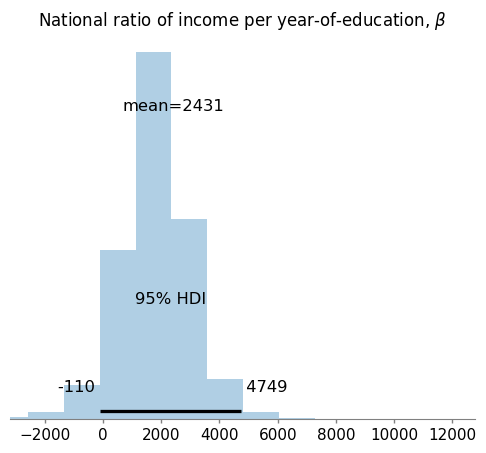

In [23]:
_, axes = plt.subplots(1,1, figsize=(6,5))

az.plot_posterior(
    TraceSeparateAlphaSeparateBeta
    , var_names = 'Beta'
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize = 11
    , ax = axes
)

axes.set_title(r"National ratio of income per year-of-education, $\beta$")

Scatterplot

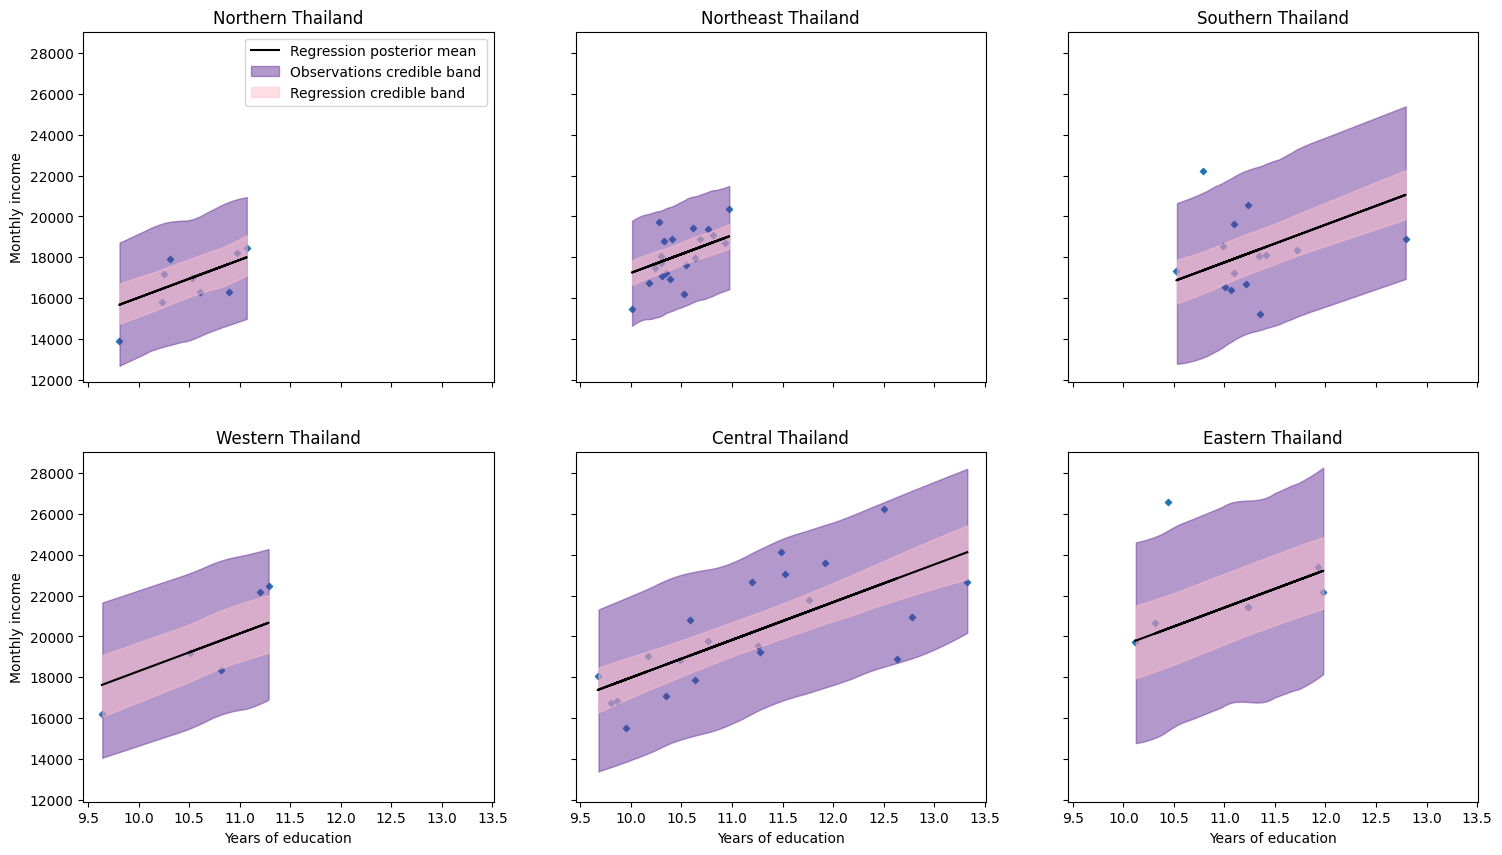

In [24]:
fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(18,10))

for k, ax in enumerate(axs.reshape(-1)):
    Aux = Dat[Dat['RegionNumber']==k]

    ax.scatter(
        Aux[PREDICTOR]
        , Aux[VARIABLE + 'Mean']
        , marker = 'D'
        , s = 10
    )

    ax.plot(
        Aux[PREDICTOR]
        , TraceVaryingAlphaCommonBeta.posterior.MeanIncome[:,:,Aux.index].mean(('chain', 'draw'))
        , label="Regression posterior mean"
        , color='k'
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceVaryingAlphaCommonBeta.posterior_predictive.Income[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='rebeccapurple'
        , fill_kwargs={'alpha': 0.5, 'label':"Observations credible band"}
        , ax = ax
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceVaryingAlphaCommonBeta.posterior.MeanIncome[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='pink'
        , fill_kwargs={'alpha': 0.5, 'label':"Regression credible band"}
        , ax = ax
    )

    ax.set_title(NumbersToRegions[k])

    if k in [0,3]:
        ax.set_ylabel(VARIABLE2)
        
        if k == 0:
            ax.legend()

    if k in [3,4,5]:
        ax.set_xlabel(PREDICTOR2)